# Workflow Interface 104: MNIST XPU
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel/openfl/blob/develop/openfl-tutorials/experimental/Workflow_Interface_104_MNIST_XPU.ipynb)

Welcome to the OpenFL Experimental Workflow Interface tutorial using Intel® Data Center GPU Max Series, also referred to as XPU in this context! Before we dive in, let's clarify some terms. XPU is a term coined by Intel to describe their line of computing devices, which includes CPUs, GPUs, FPGAs, and other accelerators. In this tutorial, we will be focusing on the Intel® Data Center GPU Max Series model, a GPU that is part of Intel's XPU lineup. 

This notebook introduces the API to get up and running with your first horizontal federated learning workflow using a XPU. This work has the following goals:

- Simplify the federated workflow representation
- Help users better understand the steps in federated learning (weight extraction, compression, etc.)
- Designed to maintain data privacy
- Aims for syntatic consistency with the Netflix MetaFlow project. Infrastructure reuse where possible.
- Introduction for use OpenFL and Intel® Extension for PyTorch* with the latest performance optimizations for Intel hardware. Intel® Extension for PyTorch* provides easy GPU acceleration for Intel discrete GPUs through the PyTorch* XPU device.
   


# Quick XPU Setup
In this tutorial, when we refer to XPU, we are specifically referring to the Intel® Data Center GPU Max Series. When using the Intel® Extension for PyTorch* package, selecting the device as 'xpu' will refer to this Intel® Data Center GPU Max Series.

For a successful setup, please follow the steps outlined in the [Installation Guide](https://intel.github.io/intel-extension-for-pytorch/xpu/2.1.10+xpu/tutorials/installation.html). This guide provides detailed information on system requirements and the installation process for the Intel® Extension for PyTorch. For a deeper understanding of features, APIs, and technical details, refer to the [Intel® Extension for PyTorch* Documentation](https://intel.github.io/intel-extension-for-pytorch/xpu/2.1.10+xpu/index.html).

Hardware Prerequisite: Intel® Data Center GPU Max Series.

This Jupyter Notebook has been tested and confirmed to work with the following versions:
- intel-extension-for-pytorch==2.0.120 (xpu)
- pytorch==2.0.1
- torchvision==0.15.2 

These versions were obtained from official Intel® channels.

Additionally, the XPU driver version used in testing was:
- [XPU_Driver==803](https://dgpu-docs.intel.com/driver/installation.html)


# What is it?

The workflow interface is a new way of composing federated learning expermients with OpenFL. It was borne through conversations with researchers and existing users who had novel use cases that didn't quite fit the standard horizontal federated learning paradigm. 

# Getting Started

First we start by installing the necessary dependencies for the workflow interface

In [ ]:
!pip install git+https://github.com/securefederatedai/openfl.git
!pip install -r workflow_interface_requirements.txt

We begin with the quintessential example of a small pytorch CNN model trained on the MNIST dataset. Let's start define our dataloaders, model, optimizer, and some helper functions like we would for any other deep learning experiment

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import numpy as np

from torchvision.datasets import MNIST
from PIL import Image

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

device = 'xpu'

# Custom MNIST
class CustomMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.device = torch.device(device)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.cpu().numpy(), mode="L")
        if self.transform is not None:
            img = self.transform(img)
        return img, target
      
# Use Custom MNIST instead of MNIST
mnist_train = CustomMNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

mnist_test = CustomMNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))    
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), kernel_size=2, stride=2))
        x = x.reshape(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def inference(network,test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        ############# code changes ###############
        data, target = data.to(device), target.to(device, dtype=torch.int64) 
        ############# code changes ###############
        with torch.xpu.amp.autocast(enabled=True, dtype=torch.bfloat16):
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
        
        correct += pred.eq(target.data.view_as(pred)).sum().cpu().numpy()
 
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
    accuracy = float(correct / len(test_loader.dataset))
    return accuracy

Next we import the `FLSpec`, `LocalRuntime`, and placement decorators.

- `FLSpec` – Defines the flow specification. User defined flows are subclasses of this.
- `Runtime` – Defines where the flow runs, infrastructure for task transitions (how information gets sent). The `LocalRuntime` runs the flow on a single node.
- `aggregator/collaborator` - placement decorators that define where the task will be assigned

In [ ]:
from copy import deepcopy

from openfl.experimental.interface import FLSpec, Aggregator, Collaborator
from openfl.experimental.runtime import LocalRuntime
from openfl.experimental.placement import aggregator, collaborator

def FedAvg(models, weights=None):
    if weights is None:
        weights = [1.0 / len(models)] * len(models)
    new_model = deepcopy(models[0])
    state_dicts = [model.state_dict() for model in models]
    state_dict = new_model.state_dict()
    for key in models[1].state_dict():
        state_dict[key] = torch.from_numpy(np.average([state[key].cpu().numpy() for state in state_dicts],
                                                      axis=0, 
                                                      weights=weights))
    new_model.load_state_dict(state_dict)
    return new_model

Now we come to the flow definition. The OpenFL Workflow Interface adopts the conventions set by Metaflow, that every workflow begins with `start` and concludes with the `end` task. The aggregator begins with an optionally passed in model and optimizer. The aggregator begins the flow with the `start` task, where the list of collaborators is extracted from the runtime (`self.collaborators = self.runtime.collaborators`) and is then used as the list of participants to run the task listed in `self.next`, `aggregated_model_validation`. The model, optimizer, and anything that is not explicitly excluded from the next function will be passed from the `start` function on the aggregator to the `aggregated_model_validation` task on the collaborator. Where the tasks run is determined by the placement decorator that precedes each task definition (`@aggregator` or `@collaborator`). Once each of the collaborators (defined in the runtime) complete the `aggregated_model_validation` task, they pass their current state onto the `train` task, from `train` to `local_model_validation`, and then finally to `join` at the aggregator. It is in `join` that an average is taken of the model weights, and the next round can begin.

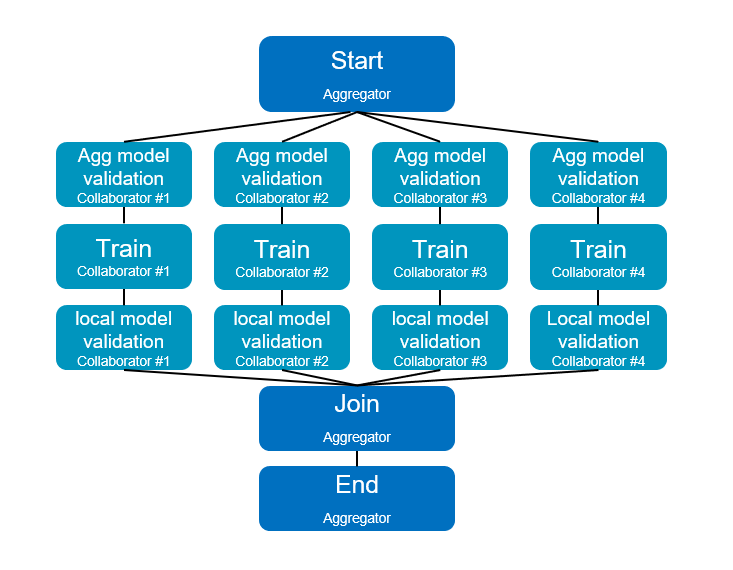

In [ ]:
# Generate model and optimizer to move to 'xpu'
model = Net()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                                   momentum=momentum)

In [ ]:
############# code changes ###############
import intel_extension_for_pytorch as ipex
model.to(device)
model, optimizer = ipex.optimize(model, optimizer=optimizer)

In [ ]:
class FederatedFlow(FLSpec):

    def __init__(self, model = None, optimizer = None, rounds=3, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.optimizer = optimizer
        self.rounds = rounds

    @aggregator
    def start(self):
        print(f'Performing initialization for model')
        self.collaborators = self.runtime.collaborators
        self.private = 10
        self.current_round = 0
        self.next(self.aggregated_model_validation,foreach='collaborators',exclude=['private'])

    @collaborator
    def aggregated_model_validation(self):
        print(f'Performing aggregated model validation for collaborator {self.input}')
        self.agg_validation_score = inference(self.model,self.test_loader)
        print(f'{self.input} value of {self.agg_validation_score}')
        self.next(self.train)

    @collaborator
    def train(self):
        self.model.train()
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate,
                                   momentum=momentum)
        train_losses = []
        for batch_idx, (data, target) in enumerate(self.train_loader):
          ############# code changes ###############
          data, target = data.to(device), target.to(device)
          self.optimizer.zero_grad()
          ############# code changes ###############
          with torch.xpu.amp.autocast(enabled=True, dtype=torch.bfloat16):
              output = self.model(data)
              loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()
          if batch_idx % log_interval == 0:
            print('Train Epoch: 1 [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
               batch_idx * len(data), len(self.train_loader.dataset),
              100. * batch_idx / len(self.train_loader), loss.item()))
            self.loss = loss.item()
            torch.save(self.model.state_dict(), 'model.pth')
            torch.save(self.optimizer.state_dict(), 'optimizer.pth')
        self.training_completed = True
        self.next(self.local_model_validation)

    @collaborator
    def local_model_validation(self):
        self.local_validation_score = inference(self.model,self.test_loader)
        print(f'Doing local model validation for collaborator {self.input}: {self.local_validation_score}')
        self.next(self.join, exclude=['training_completed'])

    @aggregator
    def join(self,inputs):
        self.average_loss = sum(input.loss for input in inputs)/len(inputs)
        self.aggregated_model_accuracy = sum(input.agg_validation_score for input in inputs)/len(inputs)
        self.local_model_accuracy = sum(input.local_validation_score for input in inputs)/len(inputs)
        print(f'Average aggregated model validation values = {self.aggregated_model_accuracy}')
        print(f'Average training loss = {self.average_loss}')
        print(f'Average local model validation values = {self.local_model_accuracy}')
        self.model = FedAvg([input.model for input in inputs])
        self.optimizer = [input.optimizer for input in inputs][0]
        self.current_round += 1
        if self.current_round < self.rounds:
            self.next(self.aggregated_model_validation, foreach='collaborators', exclude=['private'])
        else:
            self.next(self.end)
        
    @aggregator
    def end(self):
        print(f'This is the end of the flow')  

You'll notice in the `FederatedFlow` definition above that there were certain attributes that the flow was not initialized with, namely the `train_loader` and `test_loader` for each of the collaborators. These are **private_attributes** that are exposed only throught he runtime. Each participant has it's own set of private attributes: a dictionary where the key is the attribute name, and the value is the object that will be made accessible through that participant's task. 

Below, we segment shards of the MNIST dataset for **four collaborators**: Portland, Seattle, Chandler, and Portland. Each has their own slice of the dataset that's accessible via the `train_loader` or `test_loader` attribute. Note that the private attributes are flexible, and you can choose to pass in a completely different type of object to any of the collaborators or aggregator (with an arbitrary name). These private attributes will always be filtered out of the current state when transfering from collaborator to aggregator, or vice versa.  

In [ ]:
# Setup participants
aggregator = Aggregator()
aggregator.private_attributes = {}

# Setup collaborators with private attributes
collaborator_names = ['Portland', 'Seattle', 'Chandler','Bangalore']
collaborators = [Collaborator(name=name) for name in collaborator_names]

for idx, collaborator in enumerate(collaborators):
    local_train = deepcopy(mnist_train)
    local_test = deepcopy(mnist_test)
    ############# code changes ###############
    local_train.data = mnist_train.data[idx::len(collaborators)].to(device)
    local_train.targets = mnist_train.targets[idx::len(collaborators)].to(device)
    local_test.data = mnist_test.data[idx::len(collaborators)].to(device)
    local_test.targets = mnist_test.targets[idx::len(collaborators)].to(device)
    collaborator.private_attributes = {
            'train_loader': torch.utils.data.DataLoader(local_train,batch_size=batch_size_train, shuffle=True),
            'test_loader': torch.utils.data.DataLoader(local_test,batch_size=batch_size_train, shuffle=True)
    }

local_runtime = LocalRuntime(aggregator=aggregator, collaborators=collaborators, backend='single_process')
print(f'Local runtime collaborators = {local_runtime.collaborators}')

Now that we have our flow and runtime defined, let's run the experiment! 

In [ ]:
best_model = None
flflow = FederatedFlow(model,optimizer)
flflow.runtime = local_runtime
flflow.run()

Now that the flow has completed, let's get the final model and accuracy:

In [ ]:
print(f'Sample of the final model weights: {flflow.model.state_dict()["conv1.weight"][0]}')

print(f'\nFinal aggregated model accuracy for {flflow.rounds} rounds of training: {flflow.aggregated_model_accuracy}')

We can get the final model, and all other aggregator attributes after the flow completes. But what if there's an intermediate model task and its specific output that we want to look at in detail? This is where **checkpointing** and reuse of Metaflow tooling come in handy.

Let's make a tweak to the flow object, and run the experiment one more time (we can even use our previous model / optimizer as a base for the experiment)

In [ ]:
flflow2 = FederatedFlow(model=flflow.model,optimizer=flflow.optimizer,checkpoint=True)
flflow2.runtime = local_runtime
flflow2.run()

Now that the flow is complete, let's dig into some of the information captured along the way

In [ ]:
run_id = flflow2._run_id

In [ ]:
import metaflow

In [ ]:
from metaflow import Metaflow, Flow, Task, Step

In [ ]:
m = Metaflow()
list(m)

For existing users of Metaflow, you'll notice this is the same way you would examine a flow after completion. Let's look at the latest run that generated some results:

In [ ]:
f = Flow('FederatedFlow').latest_run

In [ ]:
f

And its list of steps

In [ ]:
list(f)

This matches the list of steps executed in the flow, so far so good...

In [ ]:
s = Step(f'FederatedFlow/{run_id}/train')

In [ ]:
s

In [ ]:
list(s)

Now we see **12** steps: **4** collaborators each performed **3** rounds of model training  

In [ ]:
t = Task(f'FederatedFlow/{run_id}/train/9')

In [ ]:
t

Now let's look at the data artifacts this task generated

In [ ]:
t.data

In [ ]:
t.data.input

Now let's look at its log output (stdout)

In [ ]:
print(t.stdout)

And any error logs? (stderr)

In [ ]:
print(t.stderr)

# Congratulations!
Now that you've completed your first workflow interface quickstart notebook, see some of the more advanced things you can do in our [other tutorials](broken_link), including:

- Using the LocalRuntime Ray Backend for dedicated GPU access
- Vertical Federated Learning
- Model Watermarking
- Differential Privacy
- And More!